**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.neighbors import KDTree
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer


from scipy import spatial

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        
    def fit(self, X, y):
        if self.algorithm == 'brute':
            if (type(X) != np.ndarray):
                self.x_train = X.toarray()
            else:
                self.x_train = X
            self.x_train = (self.x_train - np.mean(self.x_train, axis = 0)) / np.std(self.x_train, axis = 0)
            
        elif self.algorithm == 'kd_tree':
            if (type(X) != np.ndarray):
                self.x_train_tree = X.toarray()
            else:
                self.x_train_tree = X
            self.x_train_tree = KDTree((X - np.mean(X, axis = 0)) / np.std(X, axis = 0))
        self.y_train = y
        
    def predict(self, X):
        if (type(X) != np.ndarray):
            self.x_test = X.toarray()
        else:
            self.x_test = X
        self.x_test = (self.x_test - np.mean(self.x_test, axis = 0)) / np.std(self.x_test, axis = 0)
        
        if self.algorithm == 'brute':
            distant = spatial.distance.cdist(self.x_test, self.x_train, metric = self.metric)
            
            distant =  np.argpartition(distant, self.n_neighbors, axis=1)
            
            priznaki = self.y_train[distant][:, 0:self.n_neighbors]
            
        elif self.algorithm == 'kd_tree':
            
            distant, indices = self.x_train_tree.query(self.x_test, self.n_neighbors)
            
            priznaki = self.y_train[indices]
        
        indices = np.unique(priznaki, return_inverse=True)
        
        return indices[0][np.argmax(np.apply_along_axis(np.bincount, 1, priznaki, None, np.max(indices[1]) + 1), axis=1)]
            

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [9]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [10]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [11]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, 'Score must be equal'

In [12]:
counter_better = 0
counter_equal = 0
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
    my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    
    if accuracy_score(y_test, my_clf_pred) >  accuracy_score(y_test, sklearn_pred ):
        counter_better += 1
    elif accuracy_score(y_test, my_clf_pred) == accuracy_score(y_test, sklearn_pred ):
        counter_equal += 1
print(counter_better, 'better', counter_equal, 'equal')

205 better 567 equal


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [13]:
%time clf.fit(X_train, y_train)

CPU times: user 611 µs, sys: 76 µs, total: 687 µs
Wall time: 719 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [14]:
%time my_clf.fit(X_train, y_train)

CPU times: user 611 µs, sys: 779 µs, total: 1.39 ms
Wall time: 1.24 ms


In [15]:
%time clf.predict(X_test)

CPU times: user 2.03 ms, sys: 659 µs, total: 2.69 ms
Wall time: 2.18 ms


array([0, 1, 0, 2, 0, 2, 1, 1, 1, 0, 2, 1, 0, 2, 2])

In [16]:
%time my_clf.predict(X_test)

CPU times: user 771 µs, sys: 479 µs, total: 1.25 ms
Wall time: 825 µs


array([0, 1, 0, 2, 0, 2, 1, 1, 1, 0, 2, 1, 0, 2, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [17]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [32]:
%time clf.fit(X_train, y_train)

CPU times: user 703 µs, sys: 147 µs, total: 850 µs
Wall time: 758 µs


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [33]:
%time my_clf.fit(X_train, y_train)

CPU times: user 652 µs, sys: 273 µs, total: 925 µs
Wall time: 786 µs


In [34]:
%time clf.predict(X_test)

CPU times: user 2.15 ms, sys: 723 µs, total: 2.88 ms
Wall time: 2.3 ms


array([2, 0, 2, 1, 0, 1, 2, 0, 1, 1, 2, 2, 0, 1, 0])

In [35]:
%time my_clf.predict(X_test)

CPU times: user 1.02 ms, sys: 415 µs, total: 1.43 ms
Wall time: 1.2 ms


array([2, 0, 2, 1, 0, 1, 2, 0, 1, 1, 2, 2, 0, 1, 0])

In [36]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

In [37]:
counter_better = 0
counter_equal = 0
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
    clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
    my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
    clf.fit(X_train, y_train)
    my_clf.fit(X_train, y_train)
    sklearn_pred = clf.predict(X_test)
    my_clf_pred = my_clf.predict(X_test)
    if accuracy_score(y_test, my_clf_pred) >  accuracy_score(y_test, sklearn_pred ):
        counter_better += 1
    elif accuracy_score(y_test, my_clf_pred) == accuracy_score(y_test, sklearn_pred ):
        counter_equal += 1
print(counter_better, 'better', counter_equal, 'equal')

213 better 573 equal


**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [38]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [39]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [40]:
#data = [re.sub(r'[^0-9a-zA-Z@]+', ' ', text) for text in data]
vectorize = CountVectorizer(data, min_df = 0.005)
vectorizer = TfidfVectorizer(data, min_df = 0.005)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [41]:
matrix_tfidf = vectorizer.fit_transform(data)
matrix = vectorize.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [42]:
rkf = KFold(n_splits=3)
test = rkf.split(matrix)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [43]:
def calculate_optimal(X, y, alg='brute', metr='euclidean'):
    scores = np.array(range(19), dtype=float)
    for n in range(1, 20):
        print(n, 'iteration')
        rkf = KFold(n_splits=3, shuffle = True)
        test = rkf.split(X)
        my_clf = MyKNeighborsClassifier(n_neighbors=n+1, algorithm=alg, metric=metr)
        curr_result = []
        for training, testing in test:
            training_X, training_Y = X[training], y[training]
            testing_X, testing_Y = X[testing], y[testing]
            my_clf.fit(training_X, training_Y)
            my_clf_pred = my_clf.predict(testing_X)
            curr_result.append(accuracy_score(testing_Y, my_clf_pred))
            print(accuracy_score(testing_Y, my_clf_pred), ' number of neighbours -', n+1)
        scores[n-1] = np.mean(curr_result)
    return scores

In [44]:
new_brute_cosine_tfidf = calculate_optimal(matrix_tfidf, target, alg = 'brute', metr = 'cosine')
new_brute_cosine_tfidf

1 iteration
0.3303287380699894  number of neighbours - 2
0.3487138690002652  number of neighbours - 2
0.3391673296207902  number of neighbours - 2
2 iteration
0.34782608695652173  number of neighbours - 3
0.3688676743569345  number of neighbours - 3
0.3582604083797401  number of neighbours - 3
3 iteration
0.38547189819724287  number of neighbours - 4
0.37204985415009284  number of neighbours - 4
0.38875629806417394  number of neighbours - 4
4 iteration
0.40402969247083775  number of neighbours - 5
0.3996287456907982  number of neighbours - 5
0.40387165208167597  number of neighbours - 5
5 iteration
0.4159597030752916  number of neighbours - 6
0.420843277645187  number of neighbours - 6
0.40387165208167597  number of neighbours - 6
6 iteration
0.43584305408271473  number of neighbours - 7
0.42561654733492443  number of neighbours - 7
0.43330681516839037  number of neighbours - 7
7 iteration
0.43478260869565216  number of neighbours - 8
0.42853354547865286  number of neighbours - 8
0.434

array([0.33940331, 0.35831806, 0.38209268, 0.40251003, 0.41355821,
       0.43158881, 0.43264963, 0.44016268, 0.44599488, 0.45651412,
       0.46102177, 0.46826941, 0.46243633, 0.47498634, 0.47887688,
       0.48576938, 0.48417925, 0.49222162, 0.49213344])

In [45]:
print(new_brute_cosine_tfidf.argmax() ,new_brute_cosine_tfidf[new_brute_cosine_tfidf.argmax()])

17 0.4922216194940477


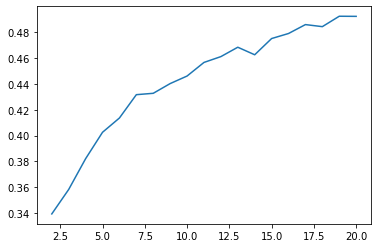

In [46]:
x = np.arange(2, 21, 1)
plt.plot(x, new_brute_cosine_tfidf)

In [48]:
i = [30,40,50,60,70,80,90,100,110]
scores = np.array(range(len(i)), dtype=float)
k = 0
for n in i:
    print(n, 'iteration')
    rkf = KFold(n_splits=3, shuffle = True)
    test = rkf.split(matrix_tfidf)
    test_clf = MyKNeighborsClassifier(n_neighbors=n, algorithm='brute', metric='cosine')
    curr_result = []
    for training, testing in test:
        training_X, training_Y = matrix_tfidf[training], target[training]
        testing_X, testing_Y = matrix_tfidf[testing], target[testing]
        test_clf.fit(training_X, training_Y)
        test_clf_pred = test_clf.predict(testing_X)
        curr_result.append(accuracy_score(testing_Y, test_clf_pred))
        print(accuracy_score(testing_Y, test_clf_pred), ' number of neighbours -', n)
    scores[k] = np.mean(curr_result)
    k += 1

30 iteration
0.5060975609756098  number of neighbours - 30
0.5160434897905065  number of neighbours - 30
0.5160434897905065  number of neighbours - 30
40 iteration
0.528101802757158  number of neighbours - 40
0.524529302572262  number of neighbours - 40
0.5332802970034474  number of neighbours - 40
50 iteration
0.5426829268292683  number of neighbours - 50
0.5407053831874834  number of neighbours - 50
0.5271811190665606  number of neighbours - 50
60 iteration
0.5455991516436903  number of neighbours - 60
0.5460090161760807  number of neighbours - 60
0.5505171042163882  number of neighbours - 60
70 iteration
0.5527571580063627  number of neighbours - 70
0.5611243701935826  number of neighbours - 70
0.5574118271015646  number of neighbours - 70
80 iteration
0.559915164369035  number of neighbours - 80
0.5481304693715194  number of neighbours - 80
0.5526385574118271  number of neighbours - 80
90 iteration
0.5604453870625663  number of neighbours - 90
0.5714664545213471  number of neighbou

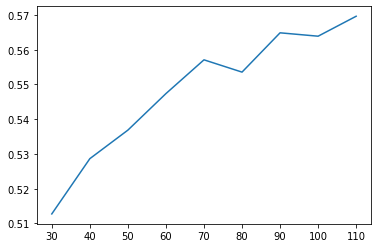

In [50]:
plt.plot(i, scores)

Чем больше соседей - тем значение лучше, возьмем 110.

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [51]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [52]:
new_data = newsgroups_test['data']
new_target = newsgroups_test['target']

In [53]:
vectorizer_test = TfidfVectorizer(new_data, min_df = 0.005)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [54]:
matrix_test_tfidf = vectorizer_test.fit_transform(new_data)

In [55]:
rkf = KFold(n_splits=3, shuffle = True)
test = rkf.split(matrix_test_tfidf)
my_clf = MyKNeighborsClassifier(n_neighbors=110, algorithm='brute', metric='cosine')
curr_result = []
for training, testing in test:
    training_X, training_Y = matrix_test_tfidf[training], new_target[training]
    testing_X, testing_Y = matrix_test_tfidf[testing], new_target[testing]
    my_clf.fit(training_X, training_Y)
    my_clf_pred = my_clf.predict(testing_X)
    curr_result.append(accuracy_score(testing_Y, my_clf_pred))
    print(accuracy_score(testing_Y, my_clf_pred), ' number of neighbours -', 110)

0.5539625647152528  number of neighbours - 110
0.5694942254082039  number of neighbours - 110
0.549800796812749  number of neighbours - 110


Ненамного отличается.